In [4]:
pd.read_csv('ETTm2.csv').describe()

,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
count,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000,69680.000000
mean,37.219411,8.554209,43.861438,8.340187,-3.430701,-2.084888,26.609799
std,10.243442,6.031270,13.061909,4.369039,6.154438,6.013584,11.886536
min,0.000000,-29.319000,10.427000,-6.648000,-14.617000,-31.462000,-2.646500
25%,30.156000,4.523000,37.421001,5.656000,-9.286000,-2.505000,16.469500
50%,37.277000,9.131000,41.415001,9.328000,-3.774000,-1.226000,26.577000
75%,44.146000,13.235000,46.186001,11.285000,2.527000,0.000000,35.585999
max,107.892998,36.438999,93.230003,29.808001,17.218000,3.731000,58.876999


In [8]:
import pandas as pd
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self,path,target_column,drop_cols, p_lag=0, test=False):
        self.df = pd.read_csv(path)
        self.df = self.df.drop(drop_cols, axis=1)
        if test: 
            self.df = self.df.iloc[round(len(self.df)*0.8):len(self.df),:]
        else: 
            self.df = self.df.iloc[0:round(len(self.df)*0.8),:]
        self.p_lag = p_lag
        self.len_df_minus_lag = len(self.df) - p_lag -1
        self.target_column = target_column
        
    def __len__(self):
        return self.len_df_minus_lag

    def __getitem__(self, idx):
        input_p_lag = torch.tensor(self.df.iloc[(idx):(idx + self.p_lag),:].astype(float).to_numpy().reshape(1,-1), requires_grad=True)
        input = input_p_lag.reshape(-1)
        target = torch.tensor(self.df[self.target_column].iloc[(idx + self.p_lag + 1),:].astype(float).to_numpy()).reshape([])
        return input, target

In [9]:
import math
import torch.nn as nn
from torch.nn.functional import normalize

class ARNet(nn.Module):
    def __init__(self, p_lag, n_features):
        super(ARNet, self).__init__()
        self.input_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/2))
        self.hidden_layer = nn.Linear(p_lag * n_features, math.ceil(p_lag * n_features/3))
        self.output_layer = nn.Linear(math.ceil(p_lag * n_features/3), 1)
        self.criterion = nn.MSELoss()

    def forward(self, input):
        input = input.float()
        input = normalize(input)
        input = self.input_layer(input)
        input = normalize(input)
        input = self.hidden_layer(input)
        return self.output_layer(input)

In [15]:
from torch.utils.data import DataLoader

p_lag = 30

net = ARNet(p_lag, 7)

train_data = DataLoader(TimeSeriesDataset(path='ETTm2.csv',target_column = ['OT'],drop_cols='date',p_lag=p_lag,test=False))
train_loss_list = []
test_data = DataLoader(TimeSeriesDataset(path='ETTm2.csv',target_column = ['OT'],drop_cols='date',p_lag=p_lag,test=True))
test_loss_list = []

torch.set_grad_enabled(True)
optimizer = torch.optim.Adam(net.parameters(), lr=1.e-5)
running_train_loss = 0.
running_test_loss = 0.
train_counter = 1
test_counter = 1
for epoch in range(5): 
    for i, data in enumerate(train_data):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = net.criterion(outputs, labels.unsqueeze(0).float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1)
        optimizer.step()
        running_train_loss += loss.item()
        train_counter += 1
        if train_counter % 10000 == 0: 
            print(f"Current (running) training loss at iteration {train_counter} : {running_train_loss/train_counter}")

    train_loss_list.append(running_train_loss/train_counter)
        
    for i, data in enumerate(test_data):
        inputs, test_labels = data
        output = net(inputs)
        test_loss = net.criterion(output, test_labels.unsqueeze(0).float())
        running_test_loss += test_loss.item()
        test_counter += 1
    test_loss_list.append(running_test_loss/test_counter)

    if epoch % 1 == 0: 
        print(f"Epoch {epoch}: ")
        print(f"Running (training) loss is {running_train_loss/train_counter}.")
        print(f"Test loss is {running_test_loss/test_counter}.")
        print("---------------------------")

for i, data in enumerate(test_data):
    inputs, labels = data
    output = net(inputs)
    print(f"predicted output is {output.item()} and true value is {labels.item()}")


Current (running) training loss at iteration 10000 : 1113.9720976303101
Current (running) training loss at iteration 20000 : 571.2330353461944
Current (running) training loss at iteration 30000 : 406.78365372857036
Current (running) training loss at iteration 40000 : 316.9839616361453
Current (running) training loss at iteration 50000 : 258.53512896752136
Epoch 0: 
Running (training) loss is 235.28379382976865.
Test loss is 243.10004476380624.
---------------------------
Current (running) training loss at iteration 60000 : 242.26561264608964
Current (running) training loss at iteration 70000 : 213.54934783866545
Current (running) training loss at iteration 80000 : 189.805144570068
Current (running) training loss at iteration 90000 : 176.79137585630153
Current (running) training loss at iteration 100000 : 161.9413154544347
Current (running) training loss at iteration 110000 : 149.16110698926673
Epoch 1: 
Running (training) loss is 147.5594640389683.
Test loss is 212.49300019700584.
----

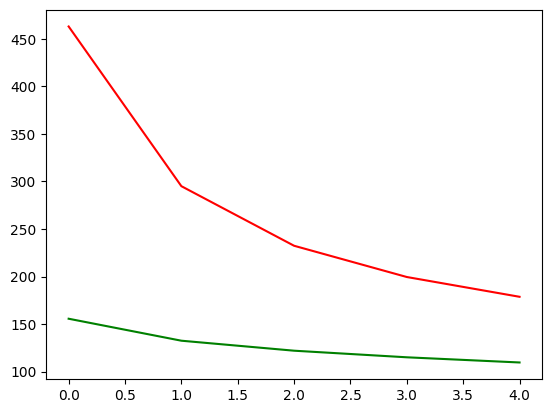

In [ ]:
import matplotlib.pyplot as plt
plt.plot(test_loss_list, 'g', train_loss_list, 'r')
plt.show()